#
# <p style="text-align: center;">Lab 4 - Classification avec le dataset MNIST Spoken</p>

Dans ce laboratoire nous allons utiliser un réseau de neurones pour classifier les signaux audios des chiffres 0 à 9 prononcés par des humains. Pour ce faire, nous allons utiliser plusieurs types de données différents pour notre réseau de neurones.

Tout d'abord nous testerons avec les signaux, puis avec le coefficients MFCC, et enfin nous utiliserons les Spectrogrammes. Nous analyserons les résultats pour les différentes approches utilisées.

Concernant la méthodologie nous utiliserons le dataset "spoken_mnist" composée de 3000 données. Nous utiliserons 20% du dataset pour le test et 80% pour l'entrainement. Nous utiliserons un réseau fully-connected implémenté avec Pytorch ainsi que la fonction de perte d'entropie croisée. Nous utiliserons également 3 réseaux de neurones à une couche cachée avec chacun une couche d'entrée correspondant au types de données utilisées.
 

#### Importation des bibliothèques nécessaire 

In [2]:
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import copy
import hub
import librosa


## Création du dataset

### Récupération de la base de données Spoken_MNIST

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



|

hub://activeloop/spoken_mnist loaded successfully.



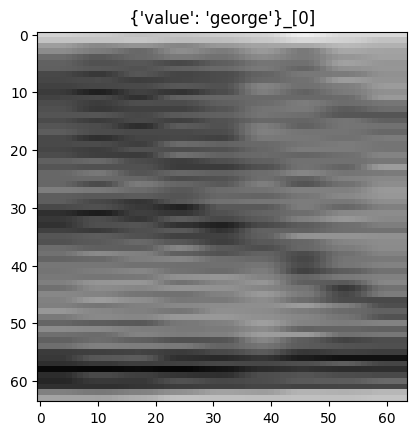

In [3]:
ds = hub.load("hub://activeloop/spoken_mnist")

# check out the first spectrogram, it's label, and who spoke it!
plt.imshow(ds.spectrograms[0].numpy())
plt.title(f"{ds.speakers[0].data()}_{ds.labels[0].numpy()}")
plt.show()


### Prétraitement des données

#### Utilisation des fichiers audios

Les fichiers audios ne sont pas tous de la même longueur. La moyenne de taille de nos fichiers audio est environ de 3500 nous allons donc mettre tous nos vecteur audios à une longueur de 3500 en prenant les 3500 premières valeurs pour les fichiers audios dont la longueur est supérieur et en complétant le tableau avec des zéros quand la longueur est inférieur à 3500.

Ainsi nous obtenons 3000 vecteurs audios de 3500 éléments. 

In [7]:
#l'éxécution de cette cellule peut prendre environ 2-3 min
duree_audio = 3500 #longueur choisie pour chaque vecteur audio
audio_data = []
for i, sample in enumerate(ds):
    a = (ds.audio[i][:duree_audio].numpy())
    current_audio = np.concatenate(a, axis=0)
    audio_data.append(current_audio)
    print(f"\rItération {i+1}/{3000}", end="", flush=True)
    

Itération 3000/3000

In [8]:
#ajout de zéros pour remplir chaque vecteurs à la longueur choisie 
for i, sample in enumerate(ds):
    if len(audio_data[i]) < duree_audio:
        audio_data[i] = np.pad(audio_data[i], (0, duree_audio-len(audio_data[i])), mode='constant', constant_values=0)

#### Utilisation des MFCC

Pour cette approche on calcul les MFCC de chaque audio. On choisi le nombre de 20 coefficient puis on fait la moyenne pour chaque audio. On se retrouve ainsi avec un vecteur de 20 coefficients pour chaque audio. On ajoute chaque vecteur de moyenne de coefficient au tenseur mfcc_data.

In [9]:
mfcc_data = []
j = 0
for j, sample in enumerate(ds):
    signal = audio_data[j]
    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=44100, n_mfcc=20).T, axis=0)
    mfcc_data.append(mfccs)
    print(f"\rItération {j+1}/{3000}", end="", flush=True)
   

Itération 3000/3000

#### Utilisation des spectrogramme

On extrait chaque spectrogramme de notre ensemble de donnée. Ils sont sous la forme d'un tenseur de taille 64x64x4

In [14]:
spect_data = []
for h, sample in enumerate(ds):
    spect_data.append(ds.spectrograms[h].numpy())
    print(f"\rItération {h+1}/{3000}", end="", flush=True)

Itération 3000/3000

### Finalisation de la création des datasets

Dans cette parties nous allons extraire les labels les ajouter dans nos 3 datasets : audio_data, mfcc_data, spect_data

On extrait les labels de notre ensemble de données et on les mets dans un tenseur

In [15]:
label_data = []
for j, sample in enumerate(ds):
    label_data.append(float(ds.labels[j].numpy()[0]))

On créer nos 3 ensembles de données où chaque vecteur audio, mfcc ou spectrogramme  est associé au label correspondant

In [16]:
audio_dataset = list(zip(audio_data, label_data))
mfcc_dataset = list(zip(mfcc_data, label_data))
spect_dataset = list(zip(spect_data, label_data))

On va à présent mélanger les datasets afin d'extraire des ensembles de test et d'entrainement qui sont représentatifs de toutes nos classes

In [17]:
def shuffleDataset(datasets):
    
    
    indices = list(range(len(datasets)))

    
    random.shuffle(indices)

    dataset_shuffle = []

    for idx in indices:
        images, label = datasets[idx]
        dataset_shuffle.append(datasets[idx])
    
    return dataset_shuffle

In [18]:
#mélange des 3 datasets
dataset_shuffle_audio = shuffleDataset(audio_dataset)
dataset_shuffle_mfcc = shuffleDataset(mfcc_dataset)
dataset_shuffle_spect = shuffleDataset(spect_dataset)

#datasets entrainements et tests audios
dataset_train_audio = dataset_shuffle_audio[:2400]
dataset_test_audio = dataset_shuffle_audio[2400:]

#datasets entrainements et tests mfcc
dataset_train_mfcc = dataset_shuffle_mfcc[:2400]
dataset_test_mfcc = dataset_shuffle_mfcc[2400:]

#datasets entrainements et tests spectrogrammes
dataset_train_spect = dataset_shuffle_spect[:2400]
dataset_test_spect = dataset_shuffle_spect[2400:]

On charge nos 6 datasets avec dataloader

In [19]:
#audio
dataloader_train_audio = torch.utils.data.DataLoader(dataset_train_audio, batch_size=25, shuffle=True)
dataloader_test_audio = torch.utils.data.DataLoader(dataset_test_audio, batch_size=1, shuffle=True)

#mfcc
dataloader_train_mfcc = torch.utils.data.DataLoader(dataset_train_mfcc, batch_size=25, shuffle=True)
dataloader_test_mfcc = torch.utils.data.DataLoader(dataset_test_mfcc, batch_size=1, shuffle=True)

#spectrogramme
dataloader_train_spect = torch.utils.data.DataLoader(dataset_train_spect, batch_size=25, shuffle=True)
dataloader_test_spect = torch.utils.data.DataLoader(dataset_test_spect, batch_size=1, shuffle=True)

## Entrainement du réseau

On choisit le GPU pour entrainer notre réseau pour avoir une meilleure puissance de calcul

In [22]:
#choix du GPU si il est disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Création des 3 réseaux de neurones

### Paramètres des réseaux

On définit les paramètres communs de nos 3 réseaux de neurones

In [23]:
#hyper-paramètre du réseau 
num_epochs = 50
learning_rate = 0.0001

#loss utilisé
criterion = nn.functional.cross_entropy

On créer une fonction qui nous permets de créer un réseau qui prend en entrée un vecteur avec la taille de notre choix. Cela nous permettra de facilement adapter notre réseau pour chaque type de données

In [24]:
def creation_nn(input_size):
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(input_size, 1000)
            self.fc2 = nn.Linear(1000, 500)
            self.fc3 = nn.Linear(500, 10)
    
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            return x
        
    model = SimpleNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    return model, optimizer
    

Ci-dessous on implémente 3 réseaux, un pour chaque approche car ils n'ont pas la même couche d'entrée 

In [25]:
input_size_audio = 3500
input_size_mfcc = 20
input_size_spect = 64*64*4

In [26]:
model_audio, optimizer_audio = creation_nn(input_size_audio)
model_mfcc, optimizer_mfcc = creation_nn(input_size_mfcc)
model_spect, optimizer_spect = creation_nn(input_size_spect)

### Boucles d'entrainements 

#### Création de la boucle d'entrainement

On créer une fonction qui nous permet d'entrainer nos réseaux avec chaque types de données choisis

In [27]:
def entrainement(dataset, input_size, model, optimizer):
    #entrainement du model
    n_total_steps = len(dataset)
    loss_value = [] 
    iteration = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(dataset):  
            images = images.float()
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
        
            #propagation avant
            outputs = model(images)
            labels = labels.squeeze()
            labels = labels.long()
            loss = criterion(outputs, labels)
        
            #rétropopagation et optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if (i+1) % 96 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                loss_value.append(loss.item())
                iteration.append(((epoch+1)*n_total_steps)-n_total_steps+i+1)

Entrainement avec données audios

In [28]:
entrainement(dataloader_train_audio, input_size_audio, model_audio, optimizer_audio)

Epoch [1/50], Step [96/96], Loss: 167.0843
Epoch [2/50], Step [96/96], Loss: 10.5887
Epoch [3/50], Step [96/96], Loss: 4.6661
Epoch [4/50], Step [96/96], Loss: 0.0190
Epoch [5/50], Step [96/96], Loss: 0.0090
Epoch [6/50], Step [96/96], Loss: 0.0013
Epoch [7/50], Step [96/96], Loss: 0.0561
Epoch [8/50], Step [96/96], Loss: 0.0865
Epoch [9/50], Step [96/96], Loss: 0.8806
Epoch [10/50], Step [96/96], Loss: 0.0671
Epoch [11/50], Step [96/96], Loss: 0.1063
Epoch [12/50], Step [96/96], Loss: 1.4182
Epoch [13/50], Step [96/96], Loss: 10.2565
Epoch [14/50], Step [96/96], Loss: 1.9492
Epoch [15/50], Step [96/96], Loss: 4.1701
Epoch [16/50], Step [96/96], Loss: 3.0910
Epoch [17/50], Step [96/96], Loss: 0.4367
Epoch [18/50], Step [96/96], Loss: 0.0022
Epoch [19/50], Step [96/96], Loss: 0.0008
Epoch [20/50], Step [96/96], Loss: 0.0035
Epoch [21/50], Step [96/96], Loss: 0.0014
Epoch [22/50], Step [96/96], Loss: 0.0001
Epoch [23/50], Step [96/96], Loss: 0.0105
Epoch [24/50], Step [96/96], Loss: 0.05

Entrainement avec données mfcc

In [29]:
entrainement(dataloader_train_mfcc, input_size_mfcc, model_mfcc, optimizer_mfcc)

Epoch [1/50], Step [96/96], Loss: 1.4293
Epoch [2/50], Step [96/96], Loss: 1.6098
Epoch [3/50], Step [96/96], Loss: 1.2785
Epoch [4/50], Step [96/96], Loss: 0.6334
Epoch [5/50], Step [96/96], Loss: 0.7100
Epoch [6/50], Step [96/96], Loss: 0.9965
Epoch [7/50], Step [96/96], Loss: 0.9923
Epoch [8/50], Step [96/96], Loss: 0.6913
Epoch [9/50], Step [96/96], Loss: 0.4752
Epoch [10/50], Step [96/96], Loss: 0.6693
Epoch [11/50], Step [96/96], Loss: 0.2428
Epoch [12/50], Step [96/96], Loss: 0.4259
Epoch [13/50], Step [96/96], Loss: 0.8531
Epoch [14/50], Step [96/96], Loss: 0.5511
Epoch [15/50], Step [96/96], Loss: 0.6605
Epoch [16/50], Step [96/96], Loss: 0.5988
Epoch [17/50], Step [96/96], Loss: 0.4076
Epoch [18/50], Step [96/96], Loss: 0.3253
Epoch [19/50], Step [96/96], Loss: 0.2579
Epoch [20/50], Step [96/96], Loss: 0.5281
Epoch [21/50], Step [96/96], Loss: 0.2390
Epoch [22/50], Step [96/96], Loss: 1.1968
Epoch [23/50], Step [96/96], Loss: 0.2084
Epoch [24/50], Step [96/96], Loss: 0.2530
E

Entrainement avec données spectrogrammes

In [30]:
entrainement(dataloader_train_spect, input_size_spect, model_spect, optimizer_spect)

Epoch [1/50], Step [96/96], Loss: 4.6451
Epoch [2/50], Step [96/96], Loss: 2.5878
Epoch [3/50], Step [96/96], Loss: 0.8375
Epoch [4/50], Step [96/96], Loss: 1.9509
Epoch [5/50], Step [96/96], Loss: 1.8686
Epoch [6/50], Step [96/96], Loss: 1.3487
Epoch [7/50], Step [96/96], Loss: 1.7216
Epoch [8/50], Step [96/96], Loss: 1.2764
Epoch [9/50], Step [96/96], Loss: 0.5114
Epoch [10/50], Step [96/96], Loss: 0.7608
Epoch [11/50], Step [96/96], Loss: 0.7577
Epoch [12/50], Step [96/96], Loss: 0.4584
Epoch [13/50], Step [96/96], Loss: 0.8152
Epoch [14/50], Step [96/96], Loss: 0.0803
Epoch [15/50], Step [96/96], Loss: 0.1133
Epoch [16/50], Step [96/96], Loss: 0.7850
Epoch [17/50], Step [96/96], Loss: 1.8574
Epoch [18/50], Step [96/96], Loss: 1.1781
Epoch [19/50], Step [96/96], Loss: 0.8383
Epoch [20/50], Step [96/96], Loss: 0.1288
Epoch [21/50], Step [96/96], Loss: 0.8130
Epoch [22/50], Step [96/96], Loss: 0.2895
Epoch [23/50], Step [96/96], Loss: 1.5471
Epoch [24/50], Step [96/96], Loss: 0.0286
E

## Test du modèle 

On créer une fonction qui nous permet de tester nos réseaux pour les différents types de données que nous avons

In [31]:
def test(dataset, model, input_size, data_type):
    with torch.no_grad():
        n_correct = 0
        n_data = 0
    
        for images, labels in dataset:
            images = images.float()
            images = images.reshape(-1, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)


            # Conversion des probabilités en prédictions binaires (0 ou 1)
            predictions = torch.argmax(probabilities)
        
    
            # Comparaison des prédictions avec les labels pour calculer la précision
            n_correct += (predictions == labels).sum().item()
            n_data += labels.size(0)
        acc = 100*  n_correct / n_data
        
        print(f'Précision du réseau pour la prédiction du chiffre prononcé avec approche', data_type, ':', acc, '%')

A présent on test nos modèles et on calcule leurs précisions pour la classification de nos données.

In [32]:
print('Performance des réseaux pour nos différentes approches :')
test(dataloader_test_audio, model_audio, input_size_audio, "audio")
test(dataloader_test_mfcc, model_mfcc, input_size_mfcc, "mfcc")
test(dataloader_test_spect, model_spect, input_size_spect, "spectrogramme")

Performance des réseaux pour nos différentes approches :
Précision du réseau pour la prédiction du chiffre prononcé avec approche audio : 23.0 %
Précision du réseau pour la prédiction du chiffre prononcé avec approche mfcc : 89.83333333333333 %
Précision du réseau pour la prédiction du chiffre prononcé avec approche spectrogramme : 88.66666666666667 %


## Conclusion

Nous avons tester différentes approches pour la classification de signaux audios.

##### Vecteurs audios 

Nous obtenons une précision de 20.1% en utilisant les vecteurs audios. On en conclu qu'il n'y a aucune généralisation pour cette approche. En effet nous avons 10 classes donc pour un réseau aléatoire on obtiendrait envion 10%. L'approche des vecteurs audio n'est donc pas fonctionnelle pour la classification de signaux audios.

##### Coefficients MFCC

Nous obtenons une précision de 89.83% en utilisant les coefficient MFCC. Ceci est un taux de précision très intérressant qui traduit une bonne généralisation sur l'ensemble de test de notre dataset. De plus les vecteur utilisés pour cette approche sont de petite taille (20) ainsi l'entrainement est très rapide pour 50 epochs. Nous pourrions aisément essayer d'entrainer sur plus d'epochs notre réseau pour essayer d'atteindre une précision encore meilleure. 

##### Spectrogrammes 

Nous obtenons de bons résultats avec cette approche avec un taux de 88.6%. Cela est un très bon taux et traduit une très bonne généralisation de notre modèle sur notre ensemble de test. Pour cette approche l'entrainement à cependant nécessité plus de ressources et donc plus de temps car nos données d'entrée sont des vecteurs de taille 64x64x4. Aussi cette approche revient à de la computer vision puisqu'on utilise l'image de nos spectrogrammes. Ainsi on peut penser qu'en utilisant un réseau de convolution on pourrait obtenir de meilleurs résultats.
